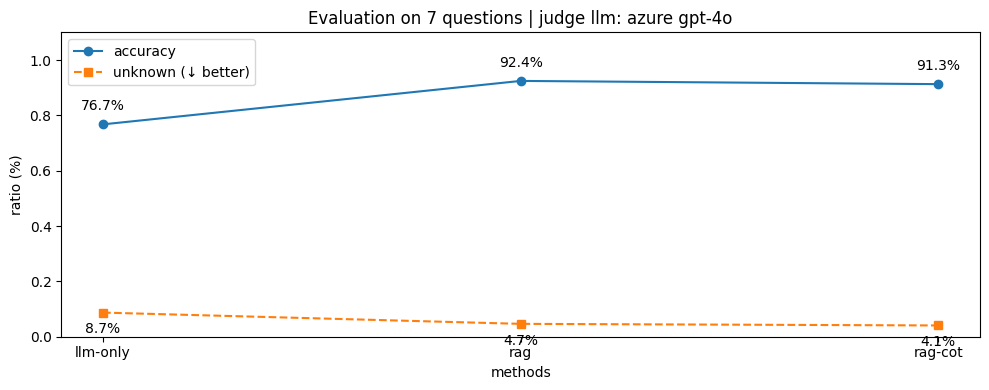

In [2]:
import matplotlib.pyplot as plt
import json
from typing import List, Dict


#read rag_metrics.json
with open("rag_metrics.json", "r") as f:
    rag_metrics = json.load(f)

with open("llm_metrics.json", "r") as f:
    llm_metrics = json.load(f)

with open("rag_cot_metrics.json", "r") as f:
    rag_cot_metrics = json.load(f)

labels = ["accuracy"]
methods = ["llm-only", "rag", "rag-cot"]
metric_matrix = [
    [llm_metrics[k] for k in labels],
    [rag_metrics[k] for k in labels],
    [rag_cot_metrics[k] for k in labels]
]

plt.figure(figsize=(10,4))
for i, label in enumerate(labels):
    plt.plot(methods, [metric_matrix[0][i], metric_matrix[1][i], metric_matrix[2][i]], "o-", label=label)
    for j, method in enumerate(methods):
        plt.annotate(f"{metric_matrix[j][i]:.1%}", (method, metric_matrix[j][i]), textcoords="offset points", xytext=(0,10), ha="center")

unknown_vals = [
    llm_metrics["unknown_count"] / llm_metrics["total_count"], 
    rag_metrics["unknown_count"] / rag_metrics["total_count"],
    rag_cot_metrics["unknown_count"] / rag_cot_metrics["total_count"]
]
plt.plot(methods, unknown_vals, "s--", label="unknown (↓ better)", color="tab:orange")
for i, method in enumerate(methods):
    plt.annotate(f"{unknown_vals[i]:.1%}", (method, unknown_vals[i]), textcoords="offset points", xytext=(0,-15), ha="center")

plt.ylim(0, 1.1)
plt.ylabel("ratio (%)")
plt.xlabel("methods")
plt.title(f"Evaluation on {len(rag_metrics)} questions | judge llm: azure gpt-4o")
plt.legend()
plt.tight_layout()
plt.show()

# Reranking 

In [3]:
from llama_index.postprocessor.colbert_rerank import ColbertRerank

colbert_reranker = ColbertRerank(
    top_n=5,
    model="colbert-ir/colbertv2.0",
    tokenizer="colbert-ir/colbertv2.0",
    keep_retrieval_score=True,
)
colbert_reranker

ColbertRerank(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7e87258f48b0>, model='colbert-ir/colbertv2.0', top_n=5, device='cpu', keep_retrieval_score=True)

In [26]:
from langchain_community.retrievers import TFIDFRetriever
from langchain_core.documents import Document

docs = [
    Document(page_content="Pandas provides data structures like Series and DataFrame for data manipulation."),
    Document(page_content="You can read CSV files into a DataFrame using pandas.read_csv()."),
    # Document(page_content="Pandas allows filtering rows using boolean indexing and conditions."),
    Document(page_content="GroupBy in pandas is used for aggregation and summarizing data."),
    Document(page_content="Missing data in pandas can be handled using fillna() or dropna()."),
    Document(page_content="Python supports object-oriented, functional, and procedural programming styles."),
    Document(page_content="List comprehensions in Python offer a concise way to create lists."),
    Document(page_content="Python's standard library includes modules for file I/O, math, and networking."),
    Document(page_content="Decorators in Python are used to modify the behavior of functions."),
    Document(page_content="Python uses indentation to define code blocks instead of braces."),
]




retriever = TFIDFRetriever.from_documents(docs, k=5)
result = retriever.invoke("pandas")
result

[Document(page_content='GroupBy in pandas is used for aggregation and summarizing data.'),
 Document(page_content='You can read CSV files into a DataFrame using pandas.read_csv().'),
 Document(page_content='Missing data in pandas can be handled using fillna() or dropna().'),
 Document(page_content='Pandas provides data structures like Series and DataFrame for data manipulation.'),
 Document(page_content='Python uses indentation to define code blocks instead of braces.')]

In [27]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder


# model = HuggingFaceCrossEncoder(model_name="lightonai/colbertv2.0")
model = HuggingFaceCrossEncoder(model_name="colbert-ir/colbertv2.0")
compressor = CrossEncoderReranker(model=model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compression_retriever

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at colbert-ir/colbertv2.0 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ContextualCompressionRetriever(base_compressor=CrossEncoderReranker(model=HuggingFaceCrossEncoder(client=CrossEncoder(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )

In [28]:
compressor.compress_documents(documents=docs,
                              query="pandas")

[Document(page_content='Pandas provides data structures like Series and DataFrame for data manipulation.'),
 Document(page_content='You can read CSV files into a DataFrame using pandas.read_csv().'),
 Document(page_content='GroupBy in pandas is used for aggregation and summarizing data.')]

In [29]:
compression_retriever.invoke("pandas")

[Document(page_content='Pandas provides data structures like Series and DataFrame for data manipulation.'),
 Document(page_content='You can read CSV files into a DataFrame using pandas.read_csv().'),
 Document(page_content='GroupBy in pandas is used for aggregation and summarizing data.')]